# Assignment 4
### Do three of six.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# %%

def download_data(force=False):
    """Download and extract course data from Zenodo."""
    import urllib.request
    import zipfile
    import os
    
    zip_path = 'data.zip'
    data_dir = 'data'
    
    if not os.path.exists(zip_path) or force:
        print("Downloading course data...")
        urllib.request.urlretrieve(
            'https://zenodo.org/records/16954427/files/data.zip?download=1',
            zip_path
        )
        print("Download complete")
    if not os.path.exists(data_dir) or force:
        print("Extracting data files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Data extracted")
    
    return data_dir

download_data()

Download complete
Extracting data files...
Data extracted


'data'

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [3]:
df = pd.read_csv('./data/mn_police_use_of_force.csv')

Index(['response_datetime', 'problem', 'is_911_call', 'primary_offense',
       'subject_injury', 'force_type', 'force_type_action', 'race', 'sex',
       'age', 'type_resistance', 'precinct', 'neighborhood'],
      dtype='object')
  subject_injury   race
0            NaN  Black
1            NaN  Black
2            NaN  White
3            NaN  Black
4            NaN  Black
race
Asian                 0.635659
Black                 0.759153
Native American       0.719388
Other / Mixed Race    0.409756
Pacific Islander      1.000000
White                 0.753595
Name: injury_missing, dtype: float64
race
Black                 7648
White                 3129
Native American        784
Other / Mixed Race     205
Asian                  129
Pacific Islander         6
Name: count, dtype: int64


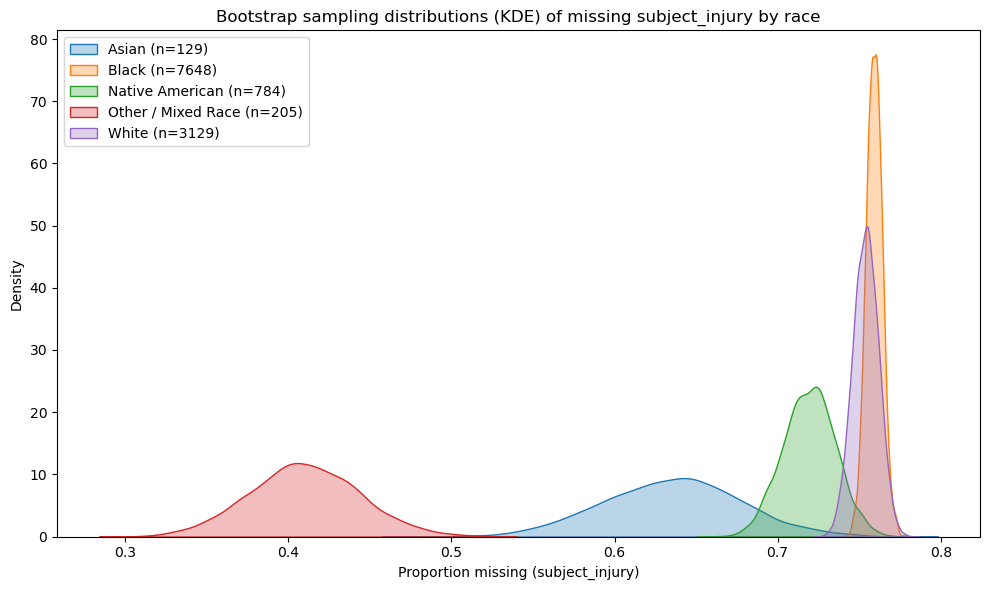

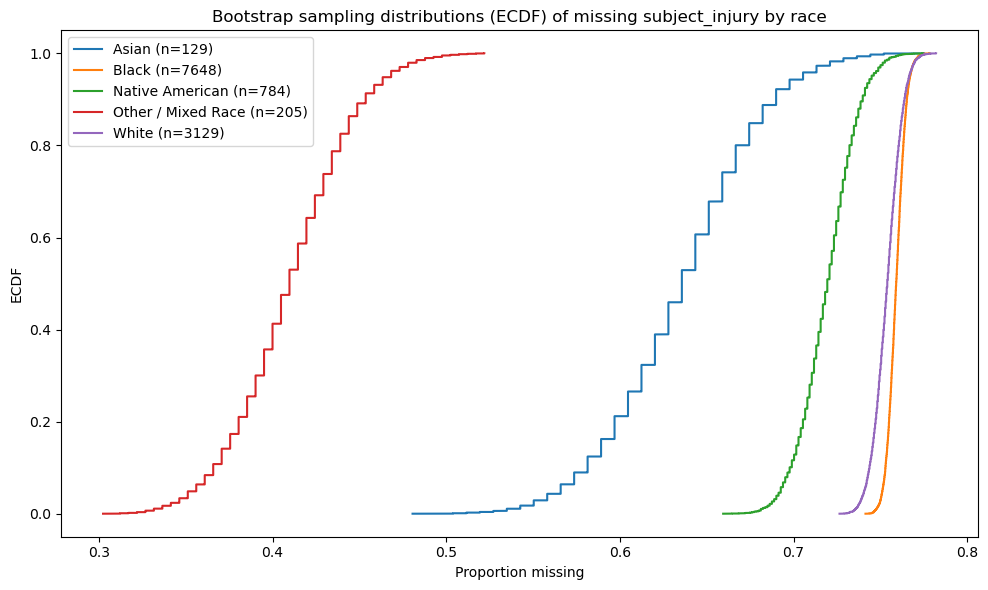

In [ ]:
print(df.columns)

df.columns = [c.strip().lower() for c in df.columns]
print(df[['subject_injury','race']].head())

df['injury_missing'] = df['subject_injury'].isna()  

prop_by_race = df.groupby('race')['injury_missing'].mean().dropna()
counts_by_race = df['race'].value_counts()
print(prop_by_race)
print(counts_by_race)

def bootstrap_prop(series_bool, n_boot=5000, random_state=None):
    rng = np.random.default_rng(random_state)
    n = len(series_bool)
    props = []
    arr = series_bool.values.astype(int)
    for _ in range(n_boot):
        sample = rng.choice(arr, size=n, replace=True)
        props.append(sample.mean())
    return np.array(props)

n_boot = 5000
boot_by_race = {}
for race, group in df.groupby('race'):
    if len(group) < 10:
        continue 
    boot_by_race[race] = bootstrap_prop(group['injury_missing'], n_boot=n_boot, random_state=42)

plt.figure(figsize=(10,6))
for race, arr in boot_by_race.items():
    sns.kdeplot(arr, label=f"{race} (n={len(df[df['race']==race])})", bw_method='scott', fill=True, alpha=0.3)
plt.xlabel('Proportion missing (subject_injury)')
plt.title('Bootstrap sampling distributions (KDE) of missing subject_injury by race')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
for race, arr in boot_by_race.items():
    x = np.sort(arr)
    y = np.arange(1, len(x)+1) / len(x)
    plt.step(x, y, where='post', label=f"{race} (n={len(df[df['race']==race])})")
plt.xlabel('Proportion missing')
plt.ylabel('ECDF')
plt.title('Bootstrap sampling distributions (ECDF) of missing subject_injury by race')
plt.legend()
plt.tight_layout()
plt.show()

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

Median SalePrice bootstrap estimate: median=160,000
90% CI for median SalePrice: [158,890, 163,500]


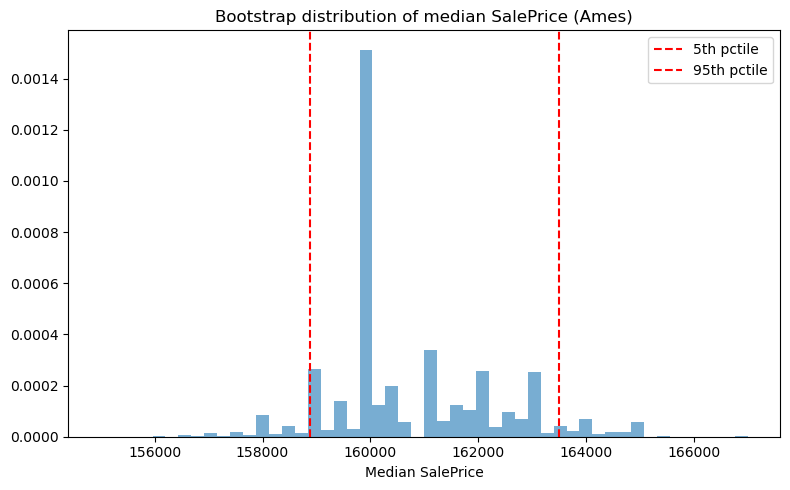

In [ ]:
ames = pd.read_csv('./data/ames_prices.csv')

var = 'price'
ames.columns = [c.strip().lower() for c in ames.columns]
var = 'price'

data = ames[var].dropna().values

def simulate_stat(data, stat_func, n_sim=5000, random_state=None):
    rng = np.random.default_rng(random_state)
    n = len(data)
    estimates = []
    for _ in range(n_sim):
        sample = rng.choice(data, size=n, replace=True)
        estimates.append(stat_func(sample))
    return np.array(estimates)

stat_func = np.median
n_sim = 5000
estimates_median = simulate_stat(data, stat_func, n_sim=n_sim, random_state=123)

def interval(L, H, estimates):
    """
    Return the L-th and H-th percentiles (L and H given as percent numbers, e.g., 5, 95)
    L < H required. Returns tuple (lower, upper).
    """
    lower = np.percentile(estimates, L)
    upper = np.percentile(estimates, H)
    return lower, upper

lower90, upper90 = interval(5, 95, estimates_median)
print(f"Median SalePrice bootstrap estimate: median={np.median(estimates_median):,.0f}")
print(f"90% CI for median SalePrice: [{lower90:,.0f}, {upper90:,.0f}]")

plt.figure(figsize=(8,5))
plt.hist(estimates_median, bins=50, density=True, alpha=0.6)
plt.axvline(lower90, color='red', linestyle='--', label='5th pctile')
plt.axvline(upper90, color='red', linestyle='--', label='95th pctile')
plt.title('Bootstrap distribution of median SalePrice (Ames)')
plt.xlabel('Median SalePrice')
plt.legend()
plt.tight_layout()
plt.show()

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

### Exercise 5
- Extend the `kde` class by adding a method to do bandwidth selection using a simple train-test split
- Extend the `kde` class by adding a method to do bandwidth seleciton by $k$-fold cross validation

### Exercise 6
In this exercise, you're going to do for LCLS what we just did for KDE: Pick the bandwidth 

Recall, the LCLS estimator is
$$
\hat{y}_{N,h}(z) = \dfrac{\frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left(\frac{z-x_i}{h}\right)}{\frac{1}{N} \sum_{i=1}^N \frac{1}{h}k\left(\frac{z-x_i}{h} \right)}.
$$
- Select two numeric variables from a data set. Split the data into training and test sets.
- Write a `predict(X_{train},Y_{train},X_{train})` function/method that takes a set of values $X_{test}$ and data $(X_{train},Y_{train})$, and computed predicted values $\hat{y}(X_{test})$ 
- Write a function/method that selects the bandwidth by **minimizing** the **mean squared error** of the squared differences between $\hat{y}(x_j)$ and $y_j$ on the test set:
$$
MSE(h) = \frac{1}{N_{test}} \sum_{j=1}^{N_{test}} (y_j - \hat{y}_{N_{train},h}(x_j))^2
$$
Be sure you understand what's happening here: The training data are used to make predictions for each test observation $x_j$, and then the prediction $\hat{y}(x_j)$ and true value $y_j$ are compared using squared difference